# Putting it all together - a case study
> A Summary of lecture in "Statistical Thinking in Python (Part 2)", via datacamp

- toc: true 
- badges: true
- comments: true
- author: Chanseok Kang
- categories: [Python, Datacamp, Data Science, Statistics]
- image: my_icons/fastai_logo.png

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

In [2]:
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    n = len(data)

    # x-data for the ECDF: x
    x = np.sort(data)

    # y-data for the ECDF: y
    y = np.arange(1, n + 1) / n

    return x, y

## Finch beaks and the need for statistics
- Data source
    - Peter and Rosemary Grant
        - 40 Years of Evolution: Darwins's Finches on Dphne Major Island
        - Princeton University Press, 2014
    - Data acquired from Dryad Digital Repository [link](http://dx.doi.org/10.5061/dryad.g6g3h)

### EDA of beak depths of Darwin's finches
For your first foray into the Darwin finch data, you will study how the beak depth (the distance, top to bottom, of a closed beak) of the finch species Geospiza scandens has changed over time. The Grants have noticed some changes of beak geometry depending on the types of seeds available on the island, and they also noticed that there was some interbreeding with another major species on Daphne Major, Geospiza fortis. These effects can lead to changes in the species over time.

In the next few problems, you will look at the beak depth of G. scandens on Daphne Major in 1975 and in 2012. To start with, let's plot all of the beak depth measurements in 1975 and 2012 in a bee swarm plot.

In [14]:
df_1 = pd.read_csv('./dataset/finch_beaks_1975.csv')
df_2 = pd.read_csv('./dataset/finch_beaks_2012.csv')

df_1['year'] = 1975
df_2['year'] = 2012

df_1.columns = ['band', 'species', 'beak_length', 'beak_depth', 'year']
df_2.columns = ['band', 'species', 'beak_length', 'beak_depth', 'year']

df = pd.concat([df_1, df_2])
df.head()

,band,species,beak_length,beak_depth,year
0,2,fortis,9.4,8.0,1975
1,9,fortis,9.2,8.3,1975
2,12,fortis,9.5,7.5,1975
3,15,fortis,9.5,8.0,1975
4,305,fortis,11.5,9.9,1975


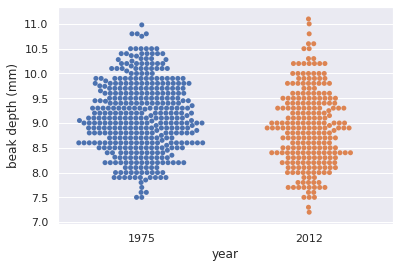

In [15]:
# Create bee swarm plot
_ = sns.swarmplot(x='year', y='beak_depth', data=df)

# Label the axes
_ = plt.xlabel('year')
_ = plt.ylabel('beak depth (mm)')

### ECDFs of beak depths
While bee swarm plots are useful, we found that ECDFs are often even better when doing EDA. Plot the ECDFs for the 1975 and 2012 beak depth measurements on the same plot.

In [36]:
bd_1975 = np.array(df[(df['year'] == 1975) & (df['species'] == 'scandens')]['beak_depth'])
bd_2012 = np.array(df[(df['year'] == 2012) & (df['species'] == 'scandens')]['beak_depth'])

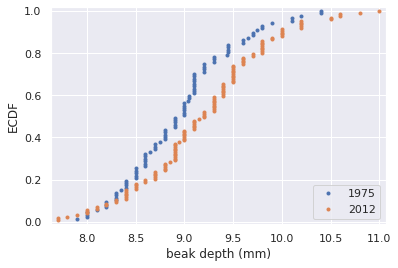

In [37]:
# Compute ECDFs
x_1975, y_1975 = ecdf(bd_1975)
x_2012, y_2012 = ecdf(bd_2012)

# Plot the ECDFs
_ = plt.plot(x_1975, y_1975, marker='.', linestyle='none')
_ = plt.plot(x_2012, y_2012, marker='.', linestyle='none')

# Set margins
plt.margins(0.02)

# Add axis labels and legend
_ = plt.xlabel('beak depth (mm)')
_ = plt.ylabel('ECDF')
_ = plt.legend(('1975', '2012'), loc='lower right')

### Parameter estimates of beak depths
Estimate the difference of the mean beak depth of the G. scandens samples from 1975 and 2012 and report a 95% confidence interval.

In [38]:
def bootstrap_replicate_1d(data, func):
    """Generate bootstrap replicate of 1D data."""
    bs_sample = np.random.choice(data, len(data))
    return func(bs_sample)

def draw_bs_reps(data, func, size=1):
    """Draw bootstrap replicates."""
    
    # Initialize array of replicates: bs_replicates
    bs_replicates = np.empty(size)
    
    # Generate replicates
    for i in range(size):
        bs_replicates[i] = bootstrap_replicate_1d(data, func)
        
    return bs_replicates

In [39]:
# Compute the difference of the sample means: mean_diff
mean_diff = np.mean(bd_2012) - np.mean(bd_1975)

# Get bootstrap replicates of means
bs_replicates_1975 = draw_bs_reps(bd_1975, np.mean, 10000)
bs_replicates_2012 = draw_bs_reps(bd_2012, np.mean, 10000)

# Compute samples of difference of means: bs_diff_replicates
bs_diff_replicates = bs_replicates_2012 - bs_replicates_1975

# Compute 95% confidence interval: conf_int
conf_int = np.percentile(bs_diff_replicates, [2.5, 97.5])

# Print the results
print('difference of means =', mean_diff, 'mm')
print('95% confidence interval =', conf_int, 'mm')

difference of means = 0.22622047244094645 mm
95% confidence interval = [0.06130095 0.39264771] mm


### Hypothesis test: Are beaks deeper in 2012?
Your plot of the ECDF and determination of the confidence interval make it pretty clear that the beaks of G. scandens on Daphne Major have gotten deeper. But is it possible that this effect is just due to random chance? In other words, what is the probability that we would get the observed difference in mean beak depth if the means were the same?

Be careful! The hypothesis we are testing is not that the beak depths come from the same distribution. For that we could use a permutation test. The hypothesis is that the means are equal. To perform this hypothesis test, we need to shift the two data sets so that they have the same mean and then use bootstrap sampling to compute the difference of means.

In [41]:
# Compute mean of combined data set: combined_mean
combined_mean = np.mean(np.concatenate((bd_1975, bd_2012)))

# Shift the samples
bd_1975_shifted = bd_1975 - np.mean(bd_1975) + combined_mean
bd_2012_shifted = bd_2012 - np.mean(bd_2012) + combined_mean

# Get bootstrap replicates of shifted data sets
bs_replicates_1975 = draw_bs_reps(bd_1975_shifted, np.mean, 10000)
bs_replicates_2012 = draw_bs_reps(bd_2012_shifted, np.mean, 10000)

# Compute replicates of difference of means: bs_diff_replicates
bs_diff_replicates = bs_replicates_2012 - bs_replicates_1975

# Compute the p-value
p = np.sum(bs_diff_replicates >= mean_diff) / len(bs_diff_replicates)

# Print p-value
print('p =', p)


p = 0.0033


We get a p-value of 0.0033, which suggests that there is a statistically significant difference. But remember: it is very important to know how different they are! In the previous exercise, you got a difference of 0.2 mm between the means. You should combine this with the statistical significance. Changing by 0.2 mm in 37 years is substantial by evolutionary standards. If it kept changing at that rate, the beak depth would double in only 400 years.

## Variation in beak shapes


### EDA of beak length and depth
Make scatter plots of beak depth (y-axis) versus beak length (x-axis) for the 1975 and 2012 specimens.

In [49]:
bl_1975 = np.array(df[(df['year'] == 1975) & (df['species'] == 'scandens')]['beak_length'])
bl_2012 = np.array(df[(df['year'] == 2012) & (df['species'] == 'scandens')]['beak_length'])

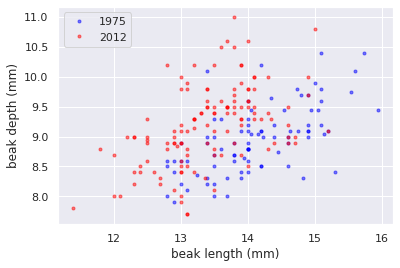

In [43]:
# Make scatter plot of 1975 data
_ = plt.plot(bl_1975, bd_1975, marker='.', linestyle='None', color='blue', alpha=0.5)

# Make scatter plot of 2012 data
_ = plt.plot(bl_2012, bd_2012, marker='.', linestyle='None', color='red', alpha=0.5)

# Label axes and make legend
_ = plt.xlabel('beak length (mm)')
_ = plt.ylabel('beak depth (mm)')
_ = plt.legend(('1975', '2012'), loc='upper left')

### Linear regressions
Perform a linear regression for both the 1975 and 2012 data. Then, perform pairs bootstrap estimates for the regression parameters. Report 95% confidence intervals on the slope and intercept of the regression line.

In [44]:
def draw_bs_pairs_linreg(x, y, size=1):
    """Perform pairs bootstrap for linear regression."""

    # Set up array of indices to sample from: inds
    inds = np.arange(len(x))

    # Initialize replicates: bs_slope_reps, bs_intercept_reps
    bs_slope_reps = np.empty(size)
    bs_intercept_reps = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_inds = np.random.choice(inds, size=len(inds))
        bs_x, bs_y = x[bs_inds], y[bs_inds]
        bs_slope_reps[i], bs_intercept_reps[i] = np.polyfit(bs_x, bs_y, deg=1)

    return bs_slope_reps, bs_intercept_reps

In [45]:
def bootstrap_replicate_1d(data, func):
    """Generate bootstrap replicate of 1D data."""
    bs_sample = np.random.choice(data, len(data))
    return func(bs_sample)

def draw_bs_reps(data, func, size=1):
    """Draw bootstrap replicates."""
    
    # Initialize array of replicates: bs_replicates
    bs_replicates = np.empty(size)
    
    # Generate replicates
    for i in range(size):
        bs_replicates[i] = bootstrap_replicate_1d(data, func)
        
    return bs_replicates

In [51]:
# Compute the linear regressions
slope_1975, intercept_1975 = np.polyfit(bl_1975, bd_1975, deg=1)
slope_2012, intercept_2012 = np.polyfit(bl_2012, bd_2012, deg=1)

# Perform pairs bootstrap for the linear regressions
bs_slope_reps_1975, bs_intercept_reps_1975 = draw_bs_pairs_linreg(bl_1975, bd_1975, 1000)
bs_slope_reps_2012, bs_intercept_reps_2012 = draw_bs_pairs_linreg(bl_2012, bd_2012, 1000)

# Compute confidence intervals of slopes
slope_conf_int_1975 = np.percentile(bs_slope_reps_1975, [2.5, 97.5])
slope_conf_int_2012 = np.percentile(bs_slope_reps_2012, [2.5, 97.5])
intercept_conf_int_1975 = np.percentile(bs_intercept_reps_1975, [2.5, 97.5])
intercept_conf_int_2012 = np.percentile(bs_intercept_reps_2012, [2.5, 97.5])

# Print the results
print('1975: slope =', slope_1975, 'conf int =', slope_conf_int_1975)
print('1975: intercept =', intercept_1975, 'conf int =', intercept_conf_int_1975)
print('2012: slope =', slope_2012, 'conf int =', slope_conf_int_2012)
print('2012: intercept =', intercept_2012, 'conf int =', intercept_conf_int_2012)

1975: slope = 0.4652051691605937 conf int = [0.33374319 0.58565272]
1975: intercept = 2.3908752365842263 conf int = [0.71814934 4.25339926]
2012: slope = 0.462630358835313 conf int = [0.32940673 0.60330509]
2012: intercept = 2.9772474982360198 conf int = [1.12723575 4.78263296]


### Displaying the linear regression results
Now, you will display your linear regression results on the scatter plot.

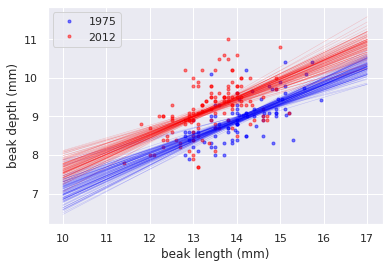

In [53]:
# Make scatter plot of 1975 data
_ = plt.plot(bl_1975, bd_1975, marker='.', linestyle='none', color='blue', alpha=0.5)

# Make scatter plot of 2012 data
_ = plt.plot(bl_2012, bd_2012, marker='.', linestyle='none', color='red', alpha=0.5)

# Label axes and make legend
_ = plt.xlabel('beak length (mm)')
_ = plt.ylabel('beak depth (mm)')
_ = plt.legend(('1975', '2012'), loc='upper left')

# Generate x-values for bootstrap lines: x
x = np.array([10, 17])

# Plot the bootstrap lines
for i in range(100):
    plt.plot(x, bs_slope_reps_1975[i] * x + bs_intercept_reps_1975[i], 
             linewidth=0.5, alpha=0.2, color='blue')
    plt.plot(x, bs_slope_reps_2012[i] * x + bs_intercept_reps_2012[i],
            linewidth=0.5, alpha=0.2, color='red')

### Beak length to depth ratio
The linear regressions showed interesting information about the beak geometry. The slope was the same in 1975 and 2012, suggesting that for every millimeter gained in beak length, the birds gained about half a millimeter in depth in both years. However, if we are interested in the shape of the beak, we want to compare the ratio of beak length to beak depth. Let's make that comparison.

In [55]:
# Compute length-to-depth ratios
ratio_1975 = bl_1975 / bd_1975
ratio_2012 = bl_2012 / bd_2012

# Compute means
mean_ratio_1975 = np.mean(ratio_1975)
mean_ratio_2012 = np.mean(ratio_2012)

# Generate bootstrap replicates of the means
bs_replicates_1975 = draw_bs_reps(ratio_1975, np.mean, 10000)
bs_replicates_2012 = draw_bs_reps(ratio_2012, np.mean, 10000)

# Compute the 99% confidence intervals
conf_int_1975 = np.percentile(bs_replicates_1975, [0.5, 99.5])
conf_int_2012 = np.percentile(bs_replicates_2012, [0.5, 99.5])

# Print the results
print('1975: mean ratio =', mean_ratio_1975, 'conf int =', conf_int_1975)
print('2012: mean ratio =', mean_ratio_2012, 'conf int =', conf_int_2012)

1975: mean ratio = 1.5788823771858533 conf int = [1.55709396 1.6006049 ]
2012: mean ratio = 1.4658342276847767 conf int = [1.44422244 1.48826439]


The mean beak length-to-depth ratio decreased by about 0.1, or 7%, from 1975 to 2012. The 99% confidence intervals are not even close to overlapping, so this is a real change. The beak shape changed.

## Calculation of heritability
- Heredity
    - The tendency for parental traits to be inherited by offspring

### EDA of heritability
The array ```bd_parent_scandens``` contains the average beak depth (in mm) of two parents of the species G. scandens. The array ```bd_offspring_scandens``` contains the average beak depth of the offspring of the respective parents. The arrays ```bd_parent_fortis``` and ```bd_offspring_fortis``` contain the same information about measurements from G. fortis birds.

Make a scatter plot of the average offspring beak depth (y-axis) versus average parental beak depth (x-axis) for both species. Use the alpha=0.5 keyword argument to help you see overlapping points.

In [69]:
df_fortis = pd.read_csv('./dataset/fortis_beak_depth_heredity.csv')
df_scandens = pd.read_csv('./dataset/scandens_beak_depth_heredity.csv')

In [70]:
df_fortis.head()

,Mid-offspr,Male BD,Female BD
0,10.70,10.90,9.3
1,9.78,10.70,8.4
2,9.48,10.70,8.1
3,9.60,10.70,9.8
4,10.27,9.85,10.4


In [71]:
df_scandens.head()

,mid_parent,mid_offspring
0,8.3318,8.4190
1,8.4035,9.2468
2,8.5317,8.1532
3,8.7202,8.0089
4,8.7089,8.2215


In [72]:
df_fortis['mid_parent'] = (df_fortis['Male BD'] + df_fortis['Female BD']) / 2
df_fortis.drop(['Male BD', 'Female BD'], axis='columns', inplace=True)
df_fortis.columns = df_scandens.columns

In [74]:
bd_parent_scandens = np.array(df_scandens['mid_parent'])
bd_offspring_scandens = np.array(df_scandens['mid_offspring'])

bd_parent_fortis = np.array(df_fortis['mid_parent'])
bd_offspring_fortis = np.array(df_fortis['mid_offspring'])

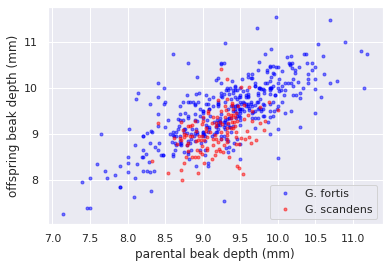

In [75]:
# Make scatter plots
_ = plt.plot(bd_parent_fortis, bd_offspring_fortis,
             marker='.', linestyle='none', color='blue', alpha=0.5)
_ = plt.plot(bd_parent_scandens, bd_offspring_scandens,
             marker='.', linestyle='none', color='red', alpha=0.5)

# Label axes
_ = plt.xlabel('parental beak depth (mm)')
_ = plt.ylabel('offspring beak depth (mm)')

# Add legend
_ = plt.legend(('G. fortis', 'G. scandens'), loc='lower right')

### Correlation of offspring and parental data
In an effort to quantify the correlation between offspring and parent beak depths, we would like to compute statistics, such as the Pearson correlation coefficient, between parents and offspring. To get confidence intervals on this, we need to do a pairs bootstrap.

In [81]:
def draw_bs_pairs(x, y, func, size=1):
    """Perform pairs bootstrap for a single statistic."""

    # Set up array of indices to sample from: inds
    inds = np.arange(len(x))

    # Initialize replicates: bs_replicates
    bs_replicates = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_inds = np.random.choice(inds, size=len(inds))
        bs_x, bs_y = x[bs_inds], y[bs_inds]
        bs_replicates[i] = func(bs_x, bs_y)

    return bs_replicates

### Pearson correlation of offspring and parental data
The Pearson correlation coefficient seems like a useful measure of how strongly the beak depth of parents are inherited by their offspring. Compute the Pearson correlation coefficient between parental and offspring beak depths for G. scandens. Do the same for G. fortis. Then, use the function you wrote in the last exercise to compute a 95% confidence interval using pairs bootstrap.

In [82]:
def pearson_r(x, y):
    """Compute Pearson correlation coefficient between two arrays
    
    Args:
        x: arrays
        y: arrays
        
    returns:
        r: int
    """
    # Compute correlation matrix: corr_mat
    corr_mat = np.corrcoef(x, y)
    
    # Return entry[0, 1]
    return corr_mat[0, 1]

In [83]:
# Compute the Pearson correlation coefficients
r_scandens = pearson_r(bd_parent_scandens, bd_offspring_scandens)
r_fortis = pearson_r(bd_parent_fortis, bd_offspring_fortis)

# Acquire 1000 bootstrap replicates of Pearson r
bs_replicates_scandens = draw_bs_pairs(bd_parent_scandens, bd_offspring_scandens, pearson_r, 1000)
bs_replicates_fortis = draw_bs_pairs(bd_parent_fortis, bd_offspring_fortis,
                                    pearson_r, 1000)

# Compute 95% confidence intervals
conf_int_scandens = np.percentile(bs_replicates_scandens, [2.5, 97.5])
conf_int_fortis = np.percentile(bs_replicates_fortis, [2.5, 97.5])

# Print results
print('G. scandens:', r_scandens, conf_int_scandens)
print('G. fortis:', r_fortis, conf_int_fortis)

G. scandens: 0.4117063629401258 [0.27809076 0.5301343 ]
G. fortis: 0.7283412395518487 [0.66929551 0.78065398]


### Measuring heritability
Remember that the Pearson correlation coefficient is the ratio of the covariance to the geometric mean of the variances of the two data sets. This is a measure of the correlation between parents and offspring, but might not be the best estimate of heritability. If we stop and think, it makes more sense to define heritability as the ratio of the covariance between parent and offspring to the variance of the parents alone. In this exercise, you will estimate the heritability and perform a pairs bootstrap calculation to get the 95% confidence interval.

This exercise highlights a very important point. Statistical inference (and data analysis in general) is not a plug-n-chug enterprise. You need to think carefully about the questions you are seeking to answer with your data and analyze them appropriately. If you are interested in how heritable traits are, the quantity we defined as the heritability is more apt than the off-the-shelf statistic, the Pearson correlation coefficient.



In [84]:
np.cov(bd_parent_fortis, bd_offspring_fortis)

array([[0.47020406, 0.34504428],
       [0.34504428, 0.47730226]])

In [86]:
def heritability(parents, offspring):
    """Compute the heritability from parent and offspring samples."""
    covariance_matrix = np.cov(parents, offspring)
    return covariance_matrix[0, 1] / covariance_matrix[0, 0]

# Compute the heritability
heritability_scandens = heritability(bd_parent_scandens, bd_offspring_scandens)
heritability_fortis = heritability(bd_parent_fortis, bd_offspring_fortis)

# Acquire 1000 bootstrap replicates of heritability
replicates_scandens = draw_bs_pairs(
        bd_parent_scandens, bd_offspring_scandens, heritability, size=1000)
        
replicates_fortis = draw_bs_pairs(
        bd_parent_fortis, bd_offspring_fortis, heritability, size=1000)


# Compute 95% confidence intervals
conf_int_scandens = np.percentile(replicates_scandens, [2.5, 97.5])
conf_int_fortis = np.percentile(replicates_fortis, [2.5, 97.5])

# Print results
print('G. scandens:', heritability_scandens, conf_int_scandens)
print('G. fortis:', heritability_fortis, conf_int_fortis)


G. scandens: 0.5485340868685982 [0.35458859 0.74433217]
G. fortis: 0.7338181655502719 [0.66833664 0.80051671]


### Is beak depth heritable at all in G. scandens?
The heritability of beak depth in G. scandens seems low. It could be that this observed heritability was just achieved by chance and beak depth is actually not really heritable in the species. You will test that hypothesis here. To do this, you will do a pairs permutation test.



In [88]:
# Initialize array of replicates: perm_replicates
perm_replicates = np.empty(10000)

# Draw replicates
for i in range(10000):
    # Permute parent beak depths
    bd_parent_permuted = np.random.permutation(bd_parent_scandens)
    perm_replicates[i] = heritability(bd_parent_permuted, bd_offspring_scandens)


# Compute p-value: p
p = np.sum(perm_replicates >= heritability_scandens) / len(perm_replicates)

# Print the p-value
print('p-val =', p)

p-val = 0.0


You get a p-value of zero, which means that none of the 10,000 permutation pairs replicates you drew had a heritability high enough to match that which was observed. This strongly suggests that beak depth is heritable in G. scandens, just not as much as in G. fortis. If you like, you can plot a histogram of the heritability replicates to get a feel for how extreme of a value of heritability you might expect by chance.

## Statistical thinking skills
- Perform EDA
    - Generate effective plots like ECDFs
    - Compute summary statistics
- Estimate parameters
    - By optimization, including linear regression
    - Determine confidence intervals
- Formulate and test hypotheses